In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [13]:
import numpy as np
import time

In [3]:
%%bash
pip install pyopencl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 919.2/919.2 kB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.4/70.4 kB 9.2 MB/s eta 0:00:00


In [ ]:
!sudo apt update
!sudo apt purge *nvidia* -y
!sudo apt install nvidia-driver-530 -y

In [5]:
import pyopencl as cl

In [6]:
def print_device_info():
  print('\n' + '=' * 60 + '\nOpenCL Platforms and Devices')
  for platform in cl.get_platforms():
    print('=' * 60)
    print('Platform - Name: ' + platform.name)
    print('Platform - Vendor: ' + platform.vendor)
    print('Platform - Version: ' + platform.version)
    print('Platform - Profile: ' + platform.profile)
    for device in platform.get_devices():
      print(' ' + '-' * 56)
      print(' Device - Name: ' \
      + device.name)
      print(' Device - Type: ' \
      + cl.device_type.to_string(device.type))
      print(' Device - Max Clock Speed: {0} Mhz'\
      .format(device.max_clock_frequency))
      print(' Device - Compute Units: {0}'\
      .format(device.max_compute_units))
      print(' Device - Local Memory: {0:.0f} KB'\
      .format(device.local_mem_size/1024.0))
      print(' Device - Constant Memory: {0:.0f} KB'\
      .format(device.max_constant_buffer_size/1024.0))
      print(' Device - Global Memory: {0:.0f} GB'\
      .format(device.global_mem_size/1073741824.0))
      print(' Device - Max Buffer/Image Size: {0:.0f} MB'\
      .format(device.max_mem_alloc_size/1048576.0))
      print(' Device - Max Work Group Size: {0:.0f}'\
      .format(device.max_work_group_size))
    print('\n')

print_device_info()


OpenCL Platforms and Devices
Platform - Name: NVIDIA CUDA
Platform - Vendor: NVIDIA Corporation
Platform - Version: OpenCL 3.0 CUDA 12.0.139
Platform - Profile: FULL_PROFILE
 --------------------------------------------------------
 Device - Name: Tesla T4
 Device - Type: ALL | GPU
 Device - Max Clock Speed: 1590 Mhz
 Device - Compute Units: 40
 Device - Local Memory: 48 KB
 Device - Constant Memory: 64 KB
 Device - Global Memory: 15 GB
 Device - Max Buffer/Image Size: 3775 MB
 Device - Max Work Group Size: 1024




In [17]:
import numpy as np
import pyopencl as cl
from skimage import io

In [8]:
# Создание контекста OpenCL и выбор платформы и устройства
platform = cl.get_platforms()[0]
device = platform.get_devices()[0]
context = cl.Context([device])
queue = cl.CommandQueue(context)

#### Тествое изображение с разрешением 768x1024

In [9]:
folder_path = '/content/gdrive/MyDrive/'
file_name01 = 'tropa_les_derevia_944568_1024x768.jpg'
file_path01 = folder_path + file_name01

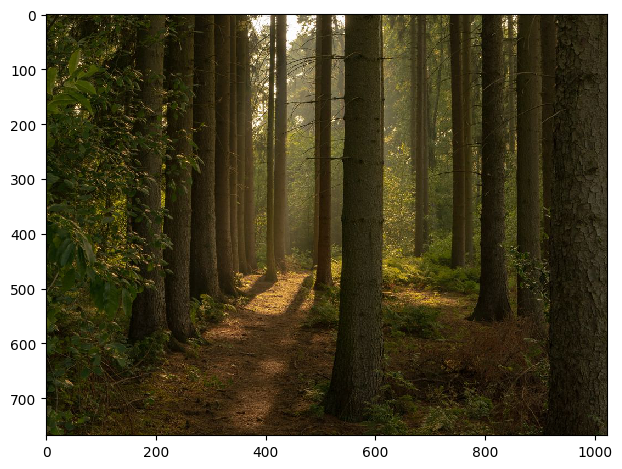

In [10]:
image = io.imread(file_path01)
io.imshow(image)

In [11]:
print(type(image[0,0,0]))

<class 'numpy.uint8'>


#### Изображение с разрешением 10240x7680

In [18]:
image = io.imread('/content/gdrive/MyDrive/tropa_les_derevia_10240x7680.jpg')
image.shape

(7680, 10240, 3)

#### Изображение с разрешением 12800x9600

In [21]:
image = io.imread('/content/gdrive/MyDrive/цветок_лепестки_белый_12800_9600.jpg')
image.shape

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (122880000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(9600, 12800, 3)

#### Изображение с разрешением 20480x15360

In [24]:
image = io.imread('/content/gdrive/MyDrive/калифорнии_штаты_Калифорния_20480 x 15360.jpg')
image.shape

DecompressionBombError: ignored

#### Программа обработки изображения на PyOpenCl

In [12]:
print(10*'=','INPUT IMAGE',10*'=')
print(f'File Sizes = {image.shape}')
image_height = image.shape[0]
print(f'Image Height = {image_height}')
image_width = image.shape[1]
print(f'Image Width = {image_width}')
num_of_channels = image.shape[2]
print(f'Number of Channels = {num_of_channels}')
num_of_pixels = image_height * image_width
print(f'Number of Pixels = {num_of_pixels}')
image_size = image_height * image_width * num_of_channels
print(f'Image Size = {image_size} uint8')

========== INPUT IMAGE ==========
File Sizes = (768, 1024, 3)
Image Height = 768
Image Width = 1024
Number of Channels = 3
Number of Pixels = 786432
Image Size = 2359296 uint8


In [13]:
print(10*'=','OUTPUT IMAGE',10*'=')
print(f'File Sizes = {image.shape}')
image_height = image.shape[0]
print(f'Image Height = {image_height}')
image_width = image.shape[1]
print(f'Image Width = {image_width}')
output_num_of_channels = 4
print(f'Number of Channels = {output_num_of_channels}')
num_of_pixels = image_height * image_width
print(f'Number of Pixels = {num_of_pixels}')
output_image_size = image_height * image_width * output_num_of_channels
print(f'Image Size = {output_image_size} uint8')

========== OUTPUT IMAGE ==========
File Sizes = (768, 1024, 3)
Image Height = 768
Image Width = 1024
Number of Channels = 4
Number of Pixels = 786432
Image Size = 3145728 uint8


In [14]:
input_image = image.astype(np.int32)
input_image = input_image.reshape(image_size)
print(type(input_image[0]))

<class 'numpy.int32'>


In [15]:
output_image = np.zeros((image_height,image_width,output_num_of_channels),dtype = np.int32)
print(output_image.shape)
output_image = output_image.reshape(output_image_size)
print(type(output_image[0]))
print(output_image.shape)

(768, 1024, 4)
<class 'numpy.int32'>
(3145728,)


In [19]:
# Определение исходного кода для ядра
grey_scale_program = cl.Program(context, """
__kernel void grey_scale(__global int *input, __global int *output, __global int *max_intensity, int num_of_pixels) {

// Получаем глобальный идентификатор
int i = get_global_id(0);
if (i<num_of_pixels)
{

    // расчет интенсивности пикселя
    int r = input[3*i];
    int g = input[3*i + 1];
    int b = input[3*i + 2];
    int gray_pixel = (r + g + b)/3;

    // поиск максимального значения интенсивности
    atomic_max(max_intensity, gray_pixel);

    // синхронизация глобальной памяти
    mem_fence(CLK_GLOBAL_MEM_FENCE);

    // получаем модифицированное 4 канальное изображение
    if (gray_pixel < *max_intensity * 0.1)
    {
      gray_pixel = 0;
      output[4*i] = 0;
      output[4*i + 1] = 0;
      output[4*i + 2] = 0;
      output[4*i + 3] = 0;
    }
    else
   {
      output[4*i] = r - (g + b)/2;
      output[4*i + 1] = g - (r + b)/2;
      output[4*i + 2] = b - (g + b)/2;
      output[4*i + 3] = r + g - 2*(abs(r - g) + b);

    }

}
}
""").build()

In [17]:
# Создание буферов памяти на устройстве
mf = cl.mem_flags
input_image_mem_object = cl.Buffer(context, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=input_image)
max_intensity_mem_object = cl.Buffer(context, mf.READ_WRITE| mf.COPY_HOST_PTR, hostbuf=np.zeros(1,dtype=np.int32))
output_image_mem_object = cl.Buffer(context, mf.WRITE_ONLY, output_image.nbytes)
print(output_image.shape)

(3145728,)


In [18]:
#work_group_size_x = 32
#work_group_size_y = 32
#block_size_z = 1

nd_range_size_x = num_of_pixels
nd_range_size_y = 1
nd_range_size_z = 1
#print(f'Work Group sizes = ({work_group_size_x}, {work_group_size_y}, {work_group_size_z}) Work Items')
print(f'ND Range sizes = ({nd_range_size_x}, {nd_range_size_y}, {nd_range_size_z}) Items')

ND Range sizes = (786432, 1, 1) Items


In [19]:
# Установка аргументов ядра OpenCL
grey_scale_program.grey_scale(queue, (nd_range_size_x,nd_range_size_y,nd_range_size_z),
                   None, input_image_mem_object, output_image_mem_object, max_intensity_mem_object, np.int32(num_of_pixels))

# Создание буфера на хосте для хранения результата
max_intensity = np.zeros(1, dtype=np.int32)
output_image = np.empty_like(output_image)

# Копирование результата с устройства на хост
cl.enqueue_copy(queue, max_intensity, max_intensity_mem_object)
cl.enqueue_copy(queue, output_image, output_image_mem_object)

In [20]:
output_image = output_image.astype(np.uint8)
output_image = output_image.reshape((image_height,image_width,output_num_of_channels))

In [21]:
max_intensity

array([255], dtype=int32)

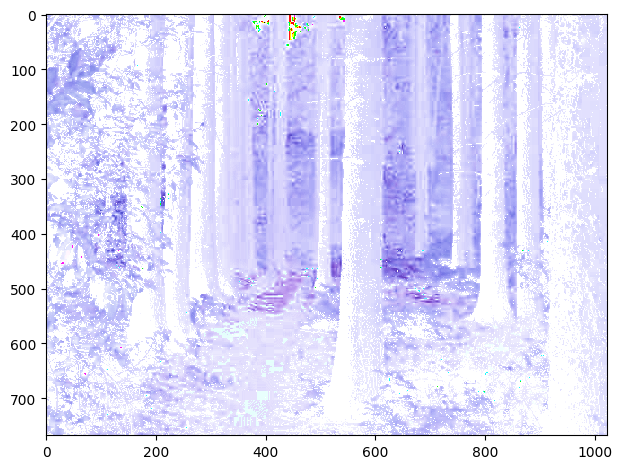

In [22]:
io.imshow(output_image)

In [23]:
output_image.shape

(768, 1024, 4)

#### Тестирование

In [22]:
elapsed_time = []
for _ in range(3):

  image_height = image.shape[0]
  image_width = image.shape[1]
  num_of_channels = image.shape[2]
  num_of_pixels = image_height * image_width
  image_size = image_height * image_width * num_of_channels

  output_num_of_channels = 4
  output_image_size = image_height * image_width * output_num_of_channels

  input_image = image.astype(np.int32)
  input_image = input_image.reshape(image_size)

  output_image = np.zeros((image_height,image_width,output_num_of_channels),dtype = np.int32)
  output_image = output_image.reshape(output_image_size)

  start_time = time.time()

  mf = cl.mem_flags
  input_image_mem_object = cl.Buffer(context, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=input_image)
  max_intensity_mem_object = cl.Buffer(context, mf.READ_WRITE| mf.COPY_HOST_PTR, hostbuf=np.zeros(1,dtype=np.int32))
  output_image_mem_object = cl.Buffer(context, mf.WRITE_ONLY, output_image.nbytes)

  nd_range_size_x = num_of_pixels
  nd_range_size_y = 1
  nd_range_size_z = 1

  # Установка аргументов ядра OpenCL
  grey_scale_program.grey_scale(queue, (nd_range_size_x,nd_range_size_y,nd_range_size_z),
                    None, input_image_mem_object, output_image_mem_object, max_intensity_mem_object, np.int32(num_of_pixels))

  # Создание буфера на хосте для хранения результата
  max_intensity = np.zeros(1, dtype=np.int32)
  output_image = np.empty_like(output_image)

  # Копирование результата с устройства на хост
  cl.enqueue_copy(queue, max_intensity, max_intensity_mem_object)
  cl.enqueue_copy(queue, output_image, output_image_mem_object)

  output_image = output_image.astype(np.uint8)
  output_image = output_image.reshape((image_height,image_width,output_num_of_channels))

  elapsed_time.append(time.time() - start_time)

  # Очистка буфера памяти
  input_image_mem_object.release()
  max_intensity_mem_object.release()
  output_image_mem_object.release()

print(f'Среднее время обработки изображения {np.mean(elapsed_time)} секунд')

Среднее время обработки изображения 2.758502165476481 секунд
